# **(Modeling Sale Price using Regression Notebook)**


Part of CRISP-DM Data Preparation


## Objective

* Fit and evaluate a regression model to predict the sale price based on the features in the data set.* 
Carry out a hyperparamter search.* 
Determine best features used in model training.

## Inputs
*outputs/datasets/collection/house_prices_records.csv* 
Instructions on which variables to use for data cleaning and feature engineering,are  found in the respectiv  notebooks.v

## Outputs* Train set (features and target)* 
Test set (features and target)* 
ML pipeline to predicthe t sale pric* e
Feature importance plot

---

## Change working directory

* Notebooks are stored in a subfolder, therefore when running the notebook in the editor, we need to change the working directory from the current folder to the parent folder.

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/house_sales_predictor/jupyter_notebooks'

## We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


## Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/house_sales_predictor'

## Load  data 

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## ML Pipeline: Regression

## Create the ML Pipeline

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.outliers   import Winsorizer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for hyperparamter optimization from CI Walkthrough Project.

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


# Grid Search CV - Sklearn

## User default hyperparameters first to find the most suitalble algorithm


In [9]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimization search using the default hyperparameters

In [10]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

* Check the results of the grid search

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.643677,0.77533,0.845186,0.069533
2,RandomForestRegressor,0.61857,0.761996,0.821982,0.073466
3,ExtraTreesRegressor,0.680311,0.761302,0.792766,0.041871
0,LinearRegression,0.689896,0.739884,0.822031,0.044905
6,XGBRegressor,0.637822,0.674272,0.705139,0.025922
4,AdaBoostRegressor,0.507364,0.662623,0.733455,0.087024
1,DecisionTreeRegressor,0.352237,0.520171,0.646729,0.107578


In [13]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

A first quick assessment of the most appropriate Regression algorithms suggests that the 'GradientBoostingRegressor' gives the best results. We will use this regression algorithm and carry out a more extensive search of hyperparameters. The 'RandomForest Regressor' and the 'ExtraTreesRegressor' also have agood mean R2 score and could be used for further analysis.

## Extensive Search for most suitable hyperparamters

For a detailed summary of the Hyperparameter test and results would be provided in readme

In [14]:
# defining model parameters for a more extensive search

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# In a workplace project, you may consider more hyperparameters and spend more time in this step
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html

params_search = {
    "GradientBoostingRegressor": {
          # 'model__n_estimators': [50, 75, 100], # gives little improvements we stick to default = 100
          # 'model__max_depth': [3, 5, 10], # gives little improvement we stick to default = 3
          'model__learning_rate': [0.05], # This learning rate consistently gave the best r2 scores, default = 0.1
          # 'model__learning_rate': [0.05, 0.07, 0.1], # default = 0.1
          # 'model__min_samples_split': [2, 25, 50, 75], # setting this to 75 also gives very good results, but we will stick to the default = 2
          # 'model__min_samples_leaf': [1, 25, 50, 75], # changing this parameter also seems to cause slight overfitting - keep default = 1
          # 'model__max_leaf_nodes': [None, 25, 50, 75], # Changing this parameter seems to often cause slight overfitting - keep default = None
    }
}

In [15]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

In [16]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                      


After extensive searching of various combinations of these 6 parameters, we find that the only parameter for which the default does not give the best result in combination with the others is the 'learning_rate' parameter, which is set to 0.05 instead of the default of 0.1. All other parameter work best in their default value configuration, leading to the best results overall.

# Assess feature importancen

The pipeline is set up in such a way that it progressively processes and narrows down the features that give the best predictive power. As designers of the pipeline we initially decided to drop two features based on the level of missing data: 'EnclosedPorch' and 'WoodDeckSF', then the SmartCorrelationSelection determines more features to drop: '1stFlrSF', 'GarageYrBlt', 'GrLivArea', and 'YearRemodAdd'. Finally, the SelectFromModel step reduces the features further to the most important and effective ones at predicting the target values.

The following code will extract these most important features:

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


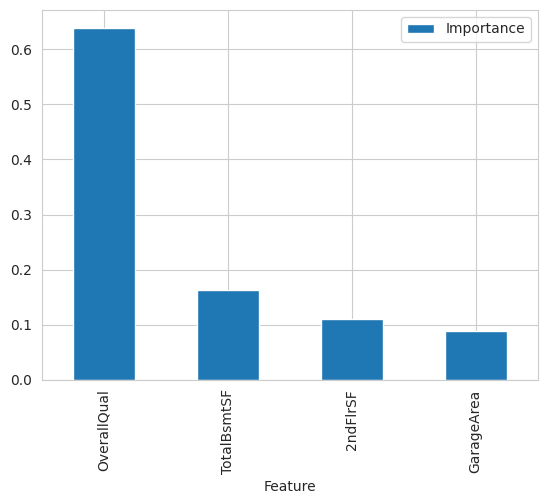

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 10 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

# Evaluate on Train and Test Sets

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.906
Mean Absolute Error: 17783.587
Mean Squared Error: 580749250.131
Root Mean Squared Error: 24098.74


* Test Set
R2 Score: 0.832
Mean Absolute Error: 22484.658
Mean Squared Error: 1158042518.86
Root Mean Squared Error: 34030.024




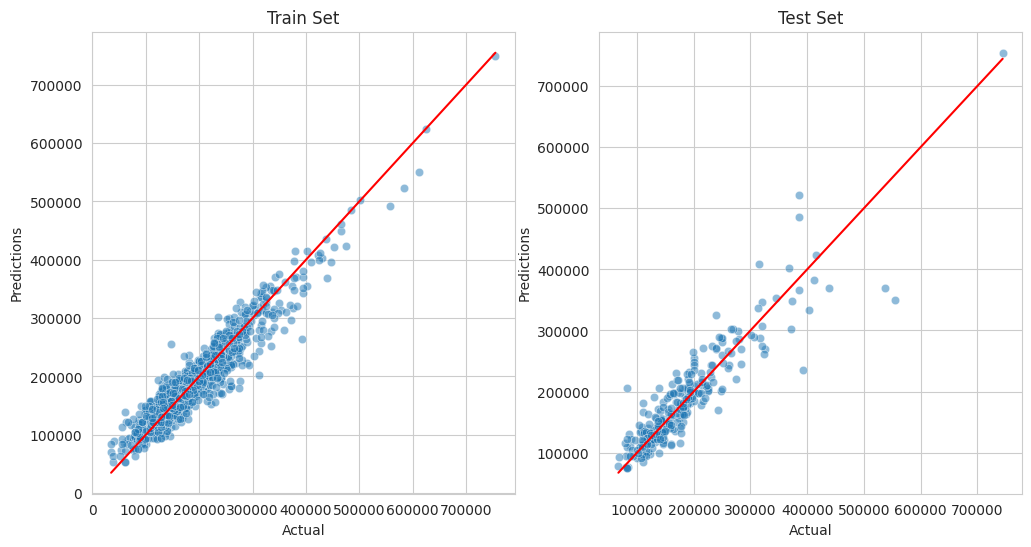

In [21]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

The performance metrics R2 are very good for both the train (0.886) and test (0.84) sets, suggesting there is no overfitting. All data points follow the regression line nicely in both data sets. We can be quite happy with this model performance, and it satisfies the business criteria of an R2 score of 0.8 or better.

Nonetheless, we can check if Principle Component Analysis will improve the results.

## Regressor with PCA

We carry out the following steps:

* PCA analysis with all components/features present in the data, which is 17 in this case.* 
Visualize the explained and accumulated variance.* 
Choose the number of components that explains at least 80-90% of the data variance, in this  case  it is quite sufficientt* .
Rewrite the pipeline substituting the feature selection step with the PCA ste* p.
Run a default hyperparameter search with appropriate regression algorith* ms.
Pick the best algorithm and rerun it with a selection of hyperparamet* Then we drs.
Draw conclusions.

In [22]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:10])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'pandas.core.frame.DataFrame'>


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


* The 17 components explain 100.0% of the data 



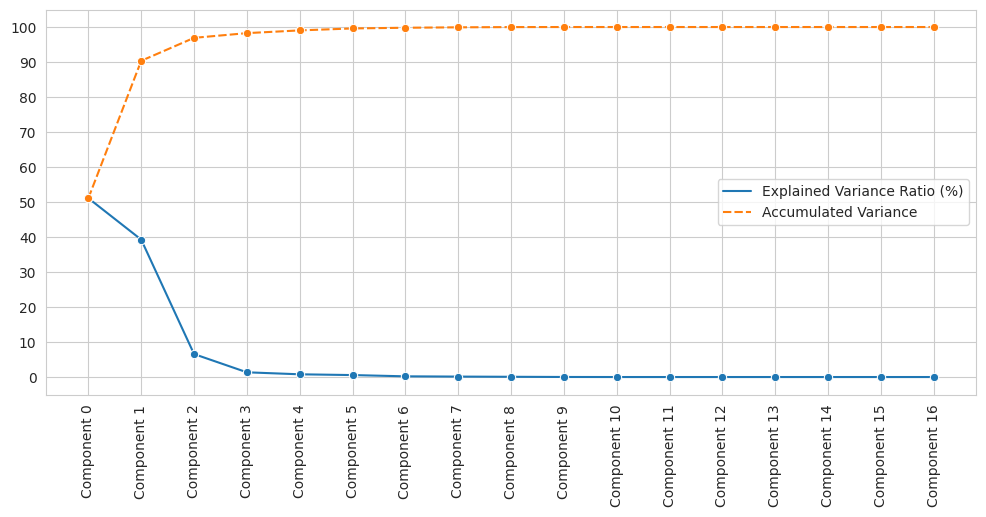

In [23]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 4 components explain 98.26% of the data 



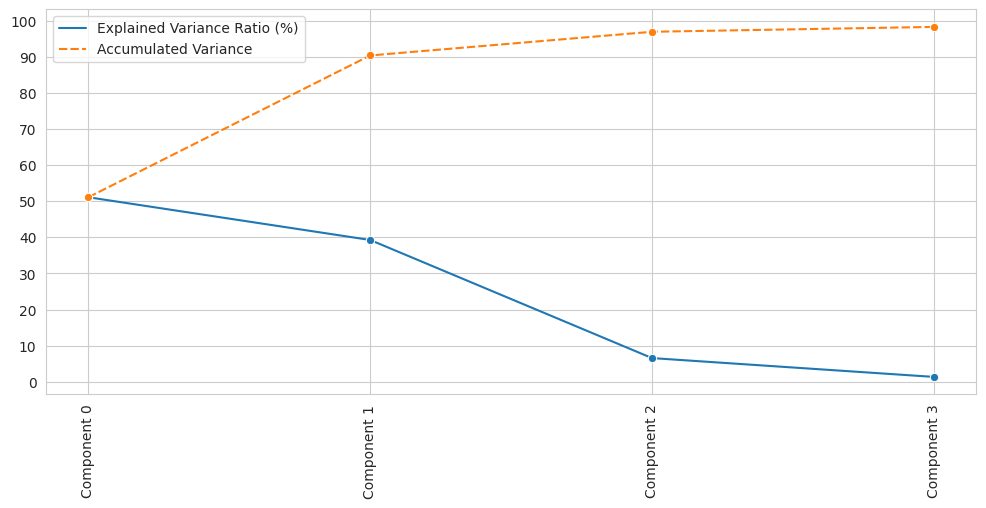

In [24]:
n_components = 4
pca_components_analysis(df_pca=df_pca, n_components=n_components)

# Rewrite the ML Pipeline for Modelling using PCA

The PCA set replaces the feature selection step in the pipeline.

In [25]:
from sklearn.decomposition import PCA

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Principle Component Analysis
        ("PCA", PCA(n_components=4, random_state=0)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [26]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [27]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [28]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [29]:
# defining model parameters for a more extensive search - we only test 3 parameters. It is unlikely that we will get any improvement over the 
# initial pipeline with 4 important features used.

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [20, 50, 100, 300],
        'model__max_depth': [3,5,8],
        'model__learning_rate': [0.03, 0.05, 0.07, 0.1],
    }
}

In [30]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [31]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
3,GradientBoostingRegressor,0.625836,0.733773,0.809695,0.060131,0.03,3,300
26,GradientBoostingRegressor,0.630714,0.733053,0.811887,0.060006,0.07,3,100
37,GradientBoostingRegressor,0.631091,0.732804,0.817536,0.05957,0.1,3,50
14,GradientBoostingRegressor,0.634849,0.732536,0.817576,0.058785,0.05,3,100
38,GradientBoostingRegressor,0.61916,0.730826,0.796054,0.05926,0.1,3,100
15,GradientBoostingRegressor,0.619578,0.729591,0.781521,0.056614,0.05,3,300
25,GradientBoostingRegressor,0.64227,0.729142,0.822476,0.059721,0.07,3,50
2,GradientBoostingRegressor,0.641739,0.728201,0.819598,0.058268,0.03,3,100
6,GradientBoostingRegressor,0.622323,0.727212,0.814195,0.062876,0.03,5,100
18,GradientBoostingRegressor,0.598584,0.724975,0.807233,0.070248,0.05,5,100


## Conclusion of PCA analysis

The PCA analysis has not lead to a better performance of the modeling pipeline and we will use the pipeline which includes the feature selection step and the previously determined best hyperparameters.

The next step is to save the best pipeline, which is the original 'GradientBoostingRegressor', set with the best parameters. Let's revisit the previous analysis to make sure that everything is set and saved correctly.

# Setting and Saving the best ML pipeline

In [32]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Feature Selection
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [33]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100],
        'model__max_depth': [3],
        'model__learning_rate': [0.05],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [None],
    }
}

In [34]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


In [35]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,GradientBoostingRegressor,0.692948,0.786326,0.847131,0.054035,0.05,3,None,1,2,100


In [36]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [37]:
# Defining the best pipeline

pipeline_regression = grid_search_pipelines[best_model].best_estimator_
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                    

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 19137.251
Mean Squared Error: 699331013.628
Root Mean Squared Error: 26444.867


* Test Set
R2 Score: 0.84
Mean Absolute Error: 22239.394
Mean Squared Error: 1107161898.508
Root Mean Squared Error: 33274.042




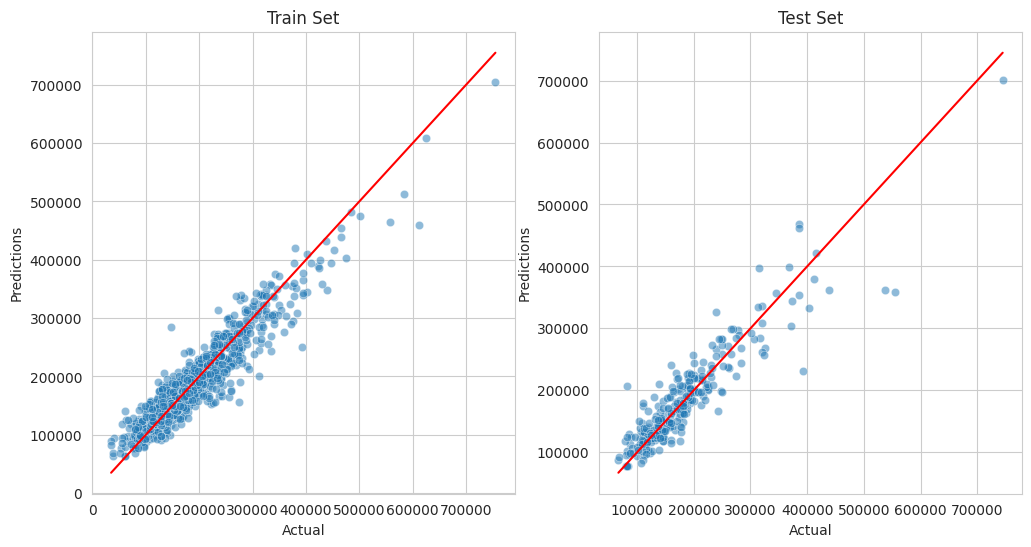

In [38]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regression)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)

# Push files to Repo

The following files will be created and pushed to the repo:

* Train Set
* Test Set
* Modeling Pipeline
* Feature importance Plot

In [39]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: Features and Target

In [40]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,11694,90.0,452.0,108,5,9,1822,NaN,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,6600,60.0,0.0,0,5,5,894,NaN,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,13360,80.0,0.0,0,7,5,876,NaN,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,NaN,857,RFn,...,13265,NaN,148.0,59,5,8,1568,NaN,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,NaN,843,RFn,...,13704,118.0,150.0,81,5,7,1541,NaN,2001,2002


In [41]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [42]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [43]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: Features and Target

In [44]:
X_test.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
529,2515,0.0,4.0,No,1219,Rec,816,NaN,484,NaN,...,32668,NaN,NaN,0,3,6,2035,NaN,1957,1975
491,958,620.0,3.0,No,403,BLQ,238,NaN,240,Unf,...,9490,79.0,0.0,0,7,6,806,NaN,1941,1950
459,979,224.0,3.0,No,185,LwQ,524,NaN,352,Unf,...,7015,NaN,161.0,0,4,5,709,NaN,1950,1950
279,1156,866.0,4.0,No,392,BLQ,768,0.0,505,Fin,...,10005,83.0,299.0,117,5,7,1160,288.0,1977,1977
655,525,NaN,3.0,No,0,Unf,525,NaN,264,Unf,...,1680,21.0,381.0,0,5,6,525,NaN,1971,1971


In [45]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [46]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [47]:

y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling Pipeline

In [48]:
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                    

In [ ]:
joblib.dump(value=pipeline_regression, filename=f"{file_path}/regression_pipeline.pkl")

## Feature Importance Plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

In [ ]:
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    # plt.show()
    plt.savefig(f'{file_path}/model_performance_evaluation.png', bbox_inches='tight')

regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)

* Push files to Repo

In [25]:
!git add .

In [27]:
!git  commit -m "modeling and Regression notebook"

[main 9221ff4] Sales price analysis notebook
 2 files changed, 45599 insertions(+)
 create mode 100644 jupyter_notebooks/.ipynb_checkpoints/Sales_prices_analysis_notebook-checkpoint.ipynb
 create mode 100644 jupyter_notebooks/Sales_prices_analysis_notebook.ipynb


In [ ]:
!git push